In [62]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm, ListedColormap
from rasterio.mask import mask
from rasterio.vrt import WarpedVRT
from rasterio.warp import Resampling
from shapely.geometry import Polygon, box

from src.common.utils import get_utm_zone_epsg
from src.constants import (
    CROP_TYPE_PREDICTION_CONFIDENCE_BAND,
    CROP_TYPE_PREDICTION_INDEX_BAND,
    LABELS_INDEX,
    MISSING_VALUE,
    TWO_WAY_LABELS_DICT,
)
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import seaborn as sns
main_result_df = pd.read_csv("/code/output/main_df.csv")
main_result_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.394782, 1.680697 49.39475...",Vineyard,31,31.0,22,35.000000,9.0
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.534244 49.52747, 1.534975 49.52760...",Vineyard,31,31.0,28,29.714286,7.0
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.731536, 2.286951 49.73235...",Vineyard,31,31.0,31,51.227273,22.0
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.286092 49.731274, 2.285546 49.7322...",Vineyard,31,31.0,31,41.000000,25.0
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.869418 50.25858, 1.870102 50.25965...",Vineyard,31,31.0,31,45.000000,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.826233 49.358066, 1.82604 49.35806...",Millet,13,13.0,31,46.666667,3.0
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.802453 49.346277, 1.802382 49.3460...",Millet,13,13.0,28,23.500000,8.0
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.812849 49.344839, 1.813091 49.3453...",Millet,13,13.0,31,47.833333,6.0
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.811558 49.343832, 1.811549 49.3438...",Millet,13,13.0,[22 28 31],28.000000,3.0


In [65]:
main_result_df.groupby("label_index").count()

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_value,predictions,confidence,n_pixels
label_index,,,,,,,,,,,
2,388,388,388,388,388,388,388,387,387,387,387
3,2912,2912,2912,2912,2912,2912,2912,2910,2910,2910,2910
4,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
5,12097,12097,12097,12097,12097,12097,12097,12075,12075,12075,12075
6,4192,4192,4192,4192,4192,4192,4192,4184,4184,4184,4184
7,58875,58875,58875,58875,58875,58875,58875,58818,58818,58818,58818
8,311,311,311,311,311,311,311,311,311,311,311
9,193,193,193,193,193,193,193,193,193,193,193
10,17,17,17,17,17,17,17,17,17,17,17


In [91]:
main_result_df

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels,predictions_clean
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.394782, 1.680697 49.39475...",Vineyard,31,31.0,22,35.000000,9.0,22
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.534244 49.52747, 1.534975 49.52760...",Vineyard,31,31.0,28,29.714286,7.0,28
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.731536, 2.286951 49.73235...",Vineyard,31,31.0,31,51.227273,22.0,31
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.286092 49.731274, 2.285546 49.7322...",Vineyard,31,31.0,31,41.000000,25.0,31
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.869418 50.25858, 1.870102 50.25965...",Vineyard,31,31.0,31,45.000000,19.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.826233 49.358066, 1.82604 49.35806...",Millet,13,13.0,31,46.666667,3.0,31
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.802453 49.346277, 1.802382 49.3460...",Millet,13,13.0,28,23.500000,8.0,28
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.812849 49.344839, 1.813091 49.3453...",Millet,13,13.0,31,47.833333,6.0,31
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.811558 49.343832, 1.811549 49.3438...",Millet,13,13.0,[22 28 31],28.000000,3.0,-1


,field_count,precision,recall,f1-score,confidence
label_index,,,,,
7,58875,0.959261,0.935864,0.947418,67.180595
21,15925,0.846397,0.738399,0.788718,51.067639
5,12097,0.733936,0.960238,0.831972,72.787999
28,11817,0.831015,0.541000,0.655356,43.490970
23,11031,0.967146,0.963376,0.965257,76.833711
19,10158,0.931795,0.989860,0.959950,80.176476
20,6921,0.565850,0.674180,0.615283,50.883190
22,6861,0.844492,0.871447,0.857758,67.821401
6,4192,0.474590,0.407681,0.438599,51.919843


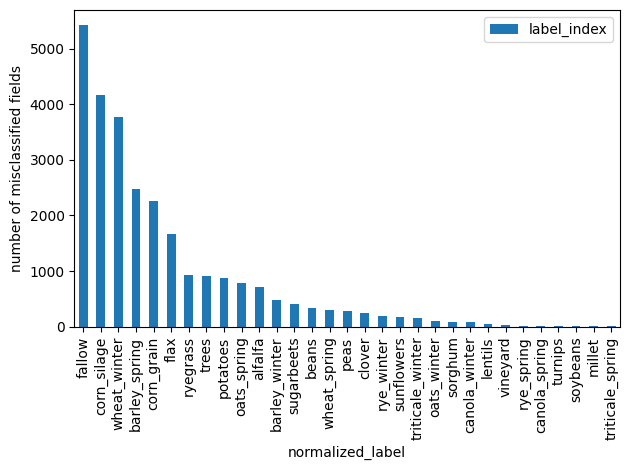

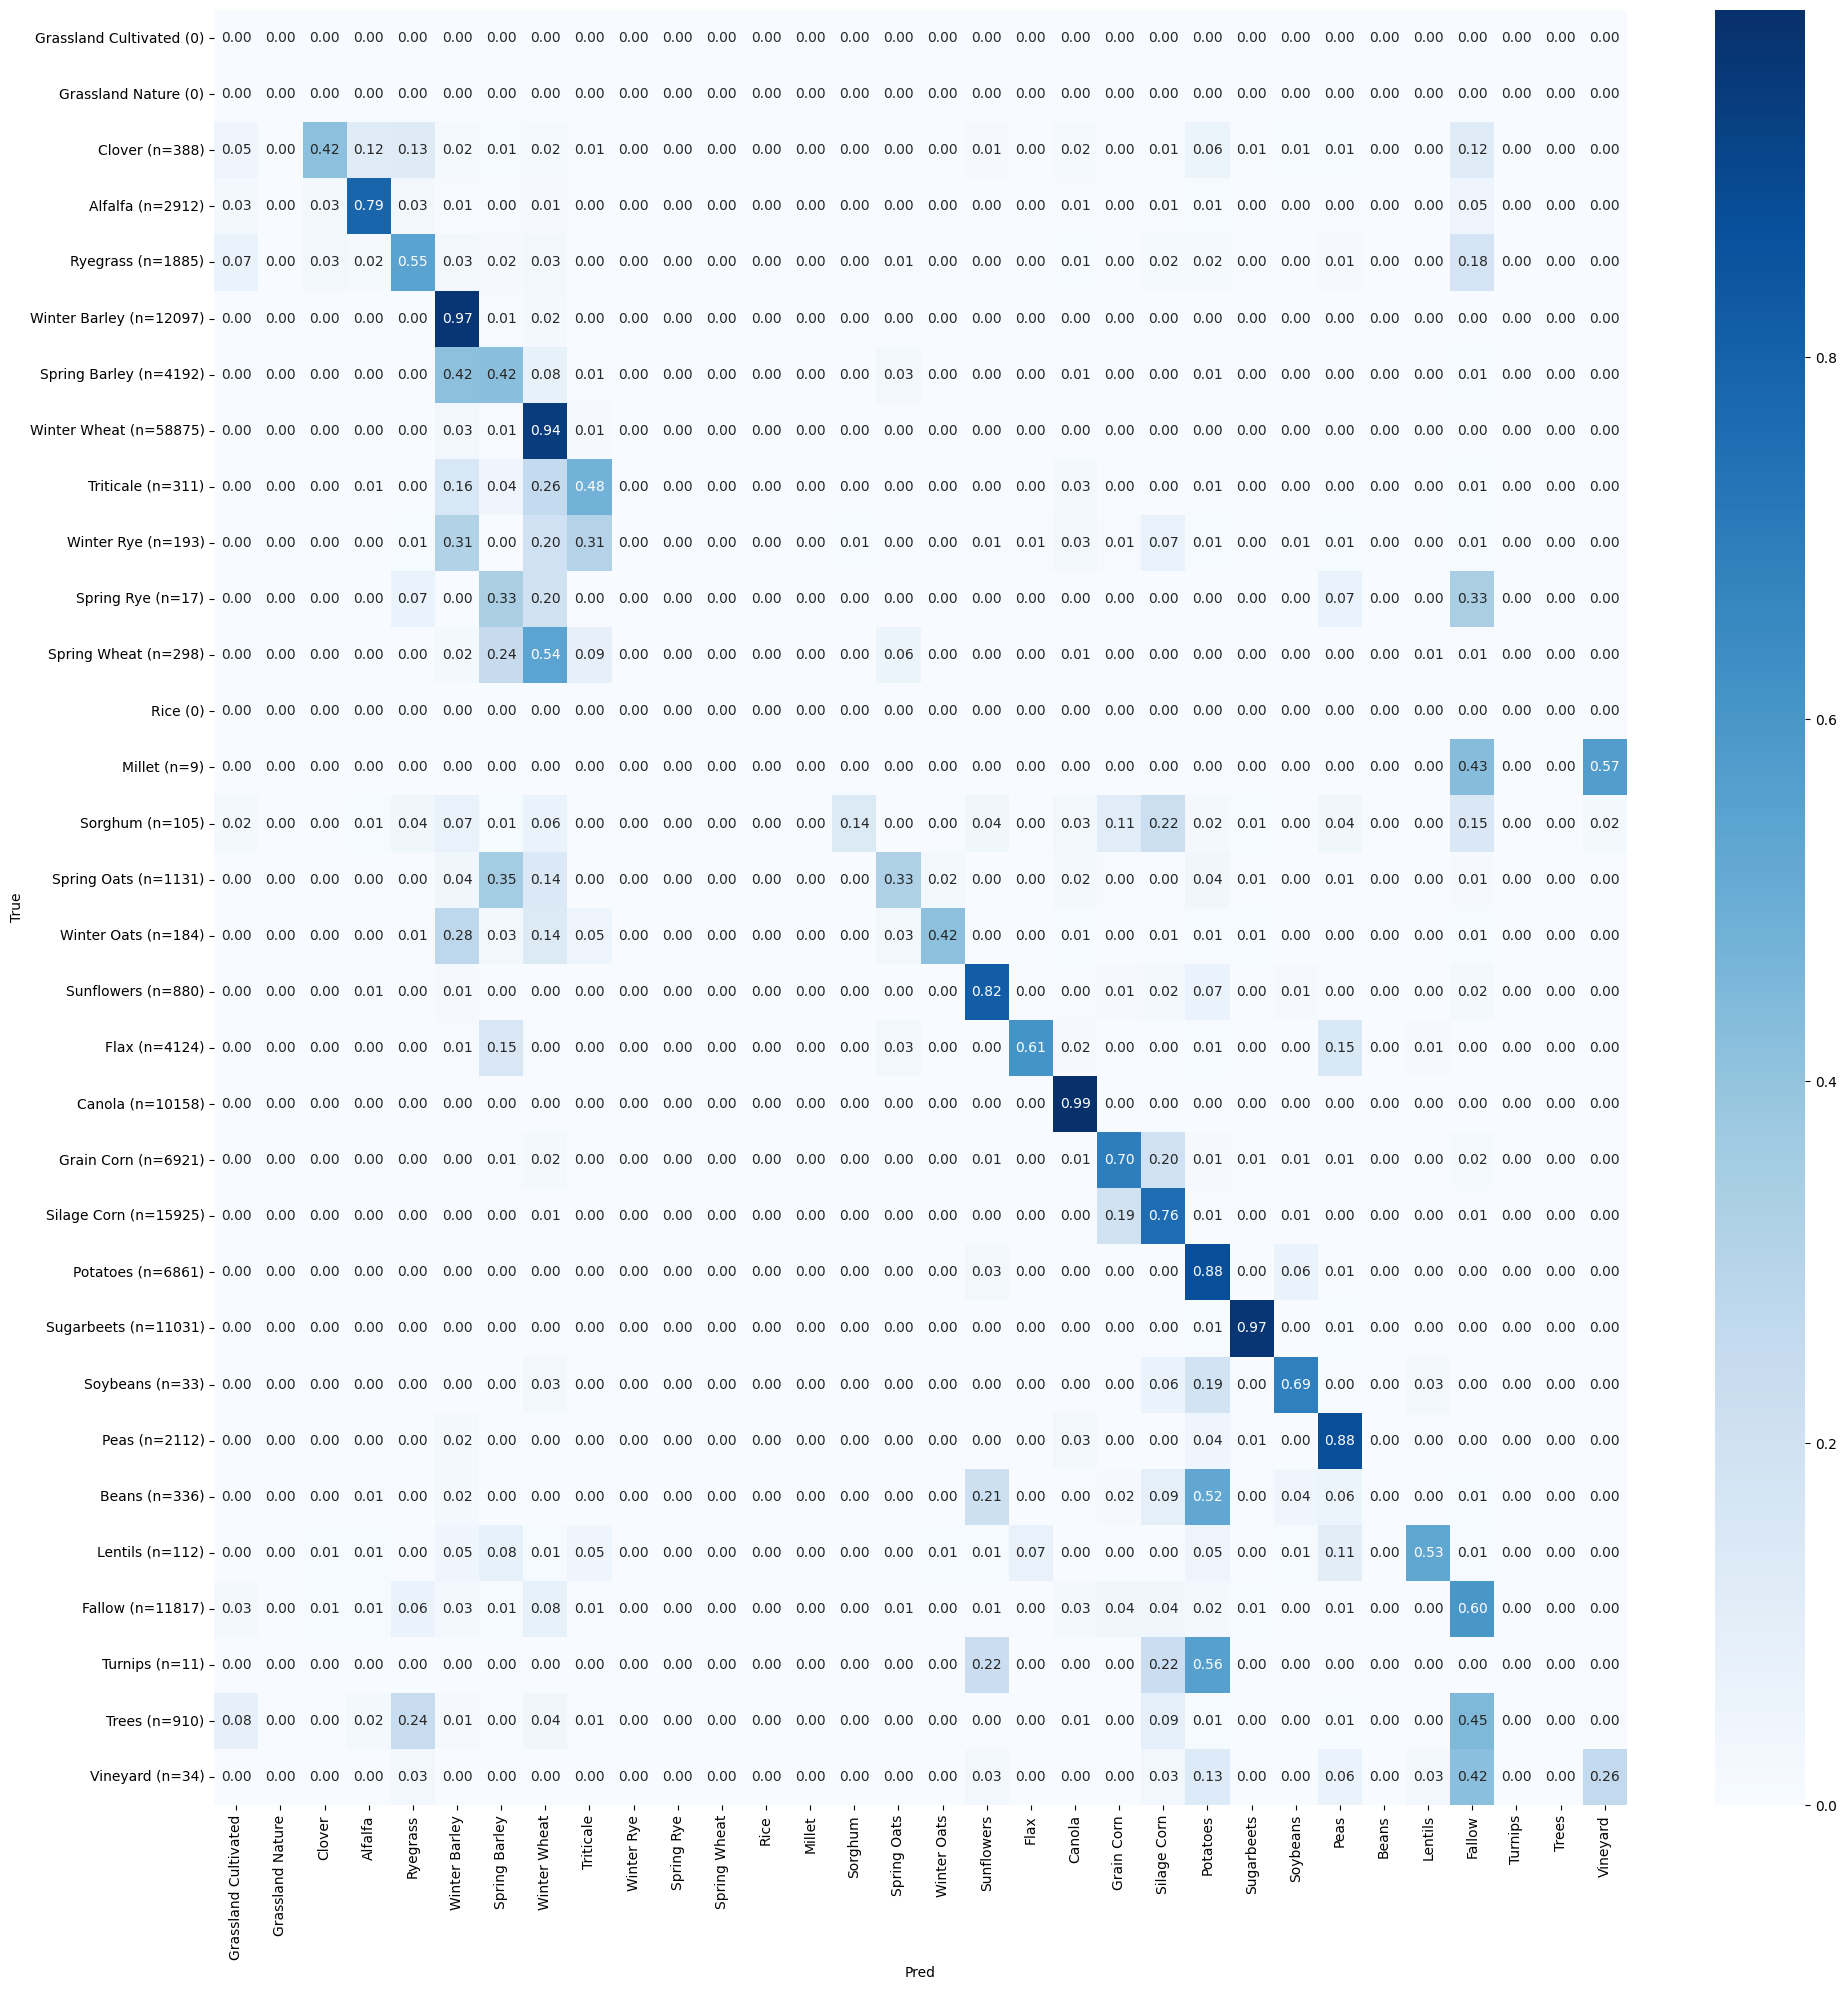

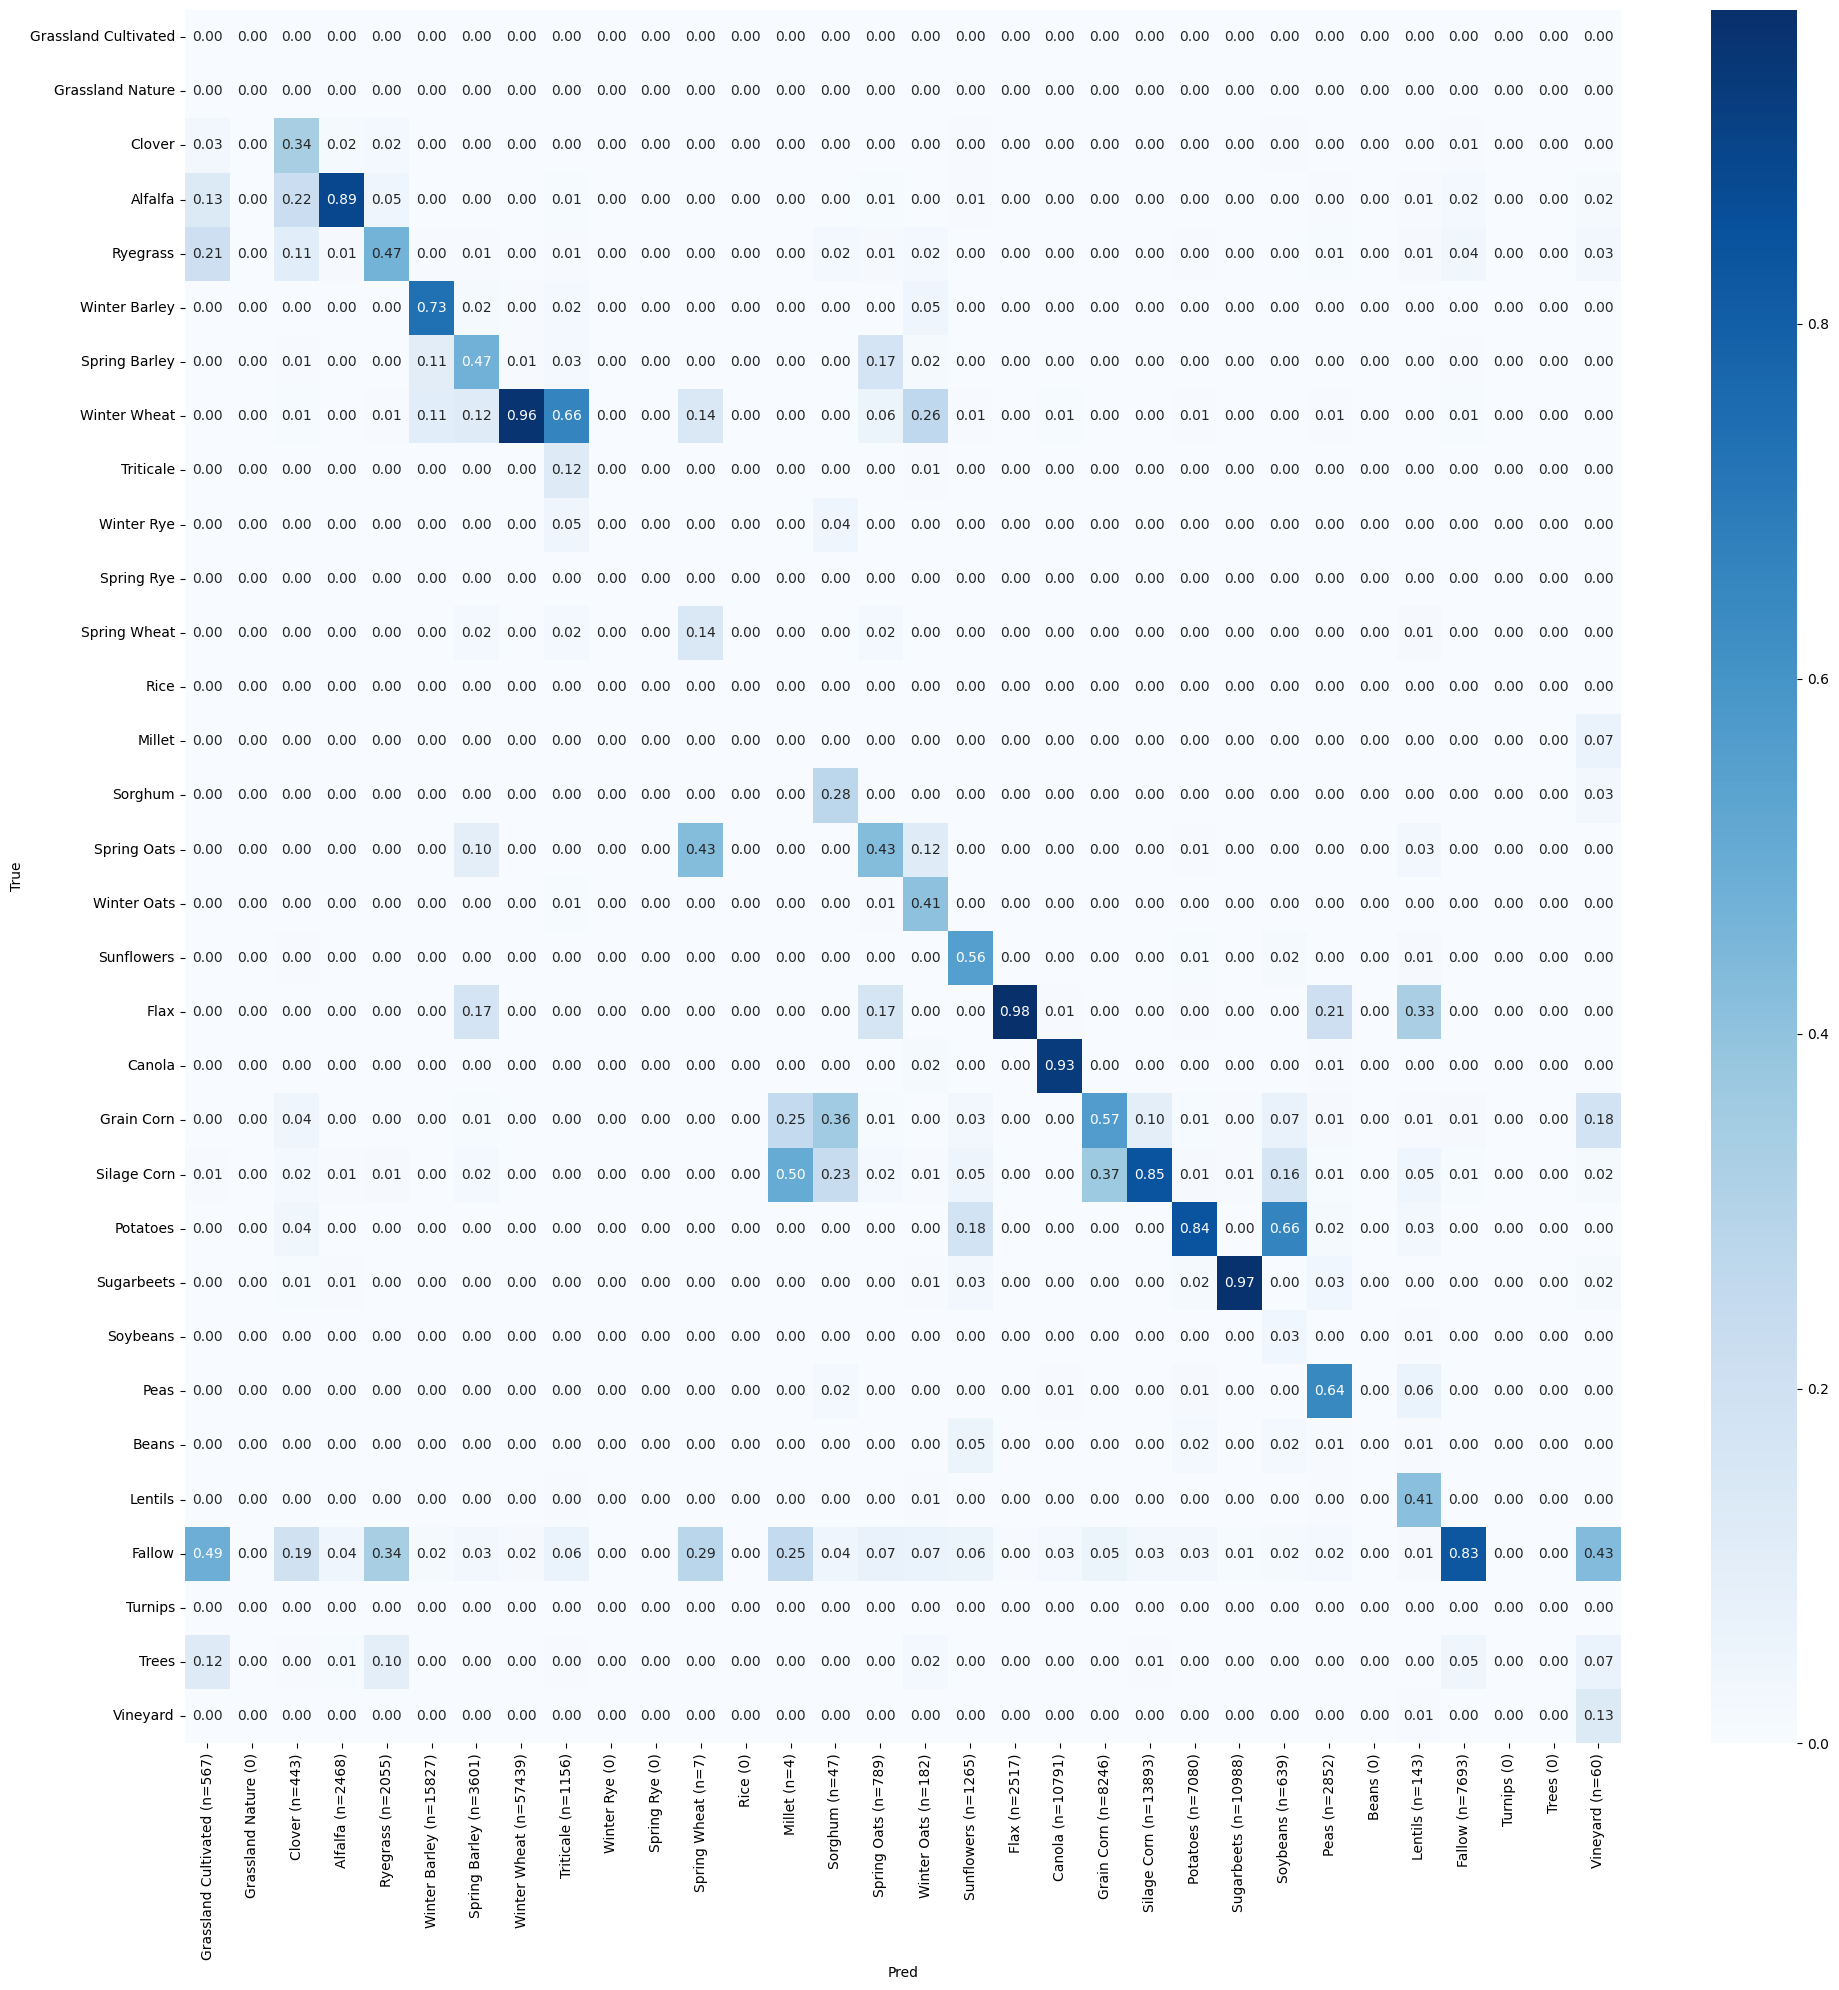

In [99]:
def map_val_to_int(p):
    try:
        return int(p)
    except (ValueError, TypeError):
        return -1
        

main_result_df["predictions_clean"] = main_result_df["predictions"].apply(
    lambda x: map_val_to_int(x)
)
misclassified_fields = main_result_df[
    main_result_df["label_index"] != main_result_df["predictions_clean"]
]
misclassified_field_counts = misclassified_fields.groupby(
    "normalized_label"
).count()

misclassified_field_counts.reset_index().sort_values(
    "label_index", ascending=False
).plot.bar(x="normalized_label", y="label_index")
plt.ylabel("number of misclassified fields")
plt.tight_layout()

field_count_by_label_crop = (
    main_result_df.groupby("label_index")
    .count()
    .sort_values("field_id", ascending=False)[["field_id"]]
    .rename(columns={"field_id": "field_count"})
)

field_count_by_predicted_crop = (
    main_result_df.groupby("predictions_clean")
    .count()
    .sort_values("field_id", ascending=False)[["field_id"]]
    .rename(columns={"field_id": "field_count"})
)

true_labels = list()
for ll in range(len(LABELS_INDEX)):
    try:
        true_labels.append(
            f"{LABELS_INDEX[ll]} (n={field_count_by_label_crop.loc[ll].values[0]})"
        )
    except KeyError:
        true_labels.append(f"{LABELS_INDEX[ll]} (0)")

pred_labels = list()
for ll in range(len(LABELS_INDEX)):
    try:
        pred_labels.append(
            f"{LABELS_INDEX[ll]} (n={field_count_by_predicted_crop.loc[ll].values[0]})"
        )
    except KeyError:
        pred_labels.append(f"{LABELS_INDEX[ll]} (0)")

cf = confusion_matrix(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    normalize="true",
)
plt.figure(figsize=(20, 20))

plot = sns.heatmap(
    cf,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    cbar=True,
    xticklabels=LABELS_INDEX,
    yticklabels=true_labels,
)
plt.xlabel("Pred")
plt.ylabel("True")
plt.tight_layout()

cf = confusion_matrix(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    normalize="pred",
)
plt.figure(figsize=(20, 20))

plot = sns.heatmap(
    cf,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    cbar=True,
    xticklabels=pred_labels,
    yticklabels=LABELS_INDEX,
)
plt.xlabel("Pred")
plt.ylabel("True")
plt.tight_layout()

precision, recall, _, _ = precision_recall_fscore_support(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    average=None,
    zero_division=np.nan,
)
f1 = f1_score(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    average=None,
    zero_division=np.nan,
)

metrics_df = pd.DataFrame(
    {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }
)
average_crop_confidence =  main_result_df[["confidence","label_index"]].groupby('label_index').mean()
metrics_df.index.name = "label_index"
metrics_df = field_count_by_label_crop.join(metrics_df)
metrics_df = metrics_df.join(average_crop_confidence)
metrics_df

In [104]:
d = pd.read_csv('/code/output/worse_10_crops.csv')
d[d['f1-score'] == 0]['field_count'].sum() / 153862


np.float64(0.009593011919772264)

In [94]:
metrics_df = metrics_df.join(average_crop_confidence)


NameError: name 'average_crop_confidence' is not defined

,confidence
label_index,
2,46.290754
3,58.427368
4,43.689485
5,72.787999
6,51.919843
7,67.180595
8,47.816800
9,47.568267
10,36.990447


In [87]:
metrics_df['label_index'] = metrics_df.index
metrics_df['label='] = metrics_df['label_index'].apply(lambda x: LABELS_INDEX[x])

label_index
7      Winter Wheat
21      Silage Corn
5     Winter Barley
28           Fallow
23       Sugarbeets
19           Canola
20       Grain Corn
22         Potatoes
6     Spring Barley
18             Flax
3           Alfalfa
25             Peas
4          Ryegrass
15      Spring Oats
30            Trees
17       Sunflowers
2            Clover
26            Beans
8         Triticale
11     Spring Wheat
9        Winter Rye
16      Winter Oats
27          Lentils
14          Sorghum
31         Vineyard
24         Soybeans
10       Spring Rye
29          Turnips
13           Millet
Name: label_index, dtype: object

In [83]:
precision, recall, _, _ = precision_recall_fscore_support(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    average=None,
    zero_division=np.nan,
)
f1 = f1_score(
    main_result_df["label_index"],
    main_result_df["predictions_clean"],
    labels=[ii for ii in range(len(LABELS_INDEX))],
    average=None,
    zero_division=np.nan,
)

metrics_df = pd.DataFrame({
    "precision": precision,
    "recall": recall,
    "f1-score": f1
})
metrics_df.index.name = 'label_index'
metrics_df = field_count_by_label_crop.join(metrics_df)
metrics_df

,field_count,precision,recall,f1-score
label_index,,,,
7,58875,0.959261,0.935864,0.947418
21,15925,0.846397,0.738399,0.788718
5,12097,0.733936,0.960238,0.831972
28,11817,0.831015,0.541000,0.655356
23,11031,0.967146,0.963376,0.965257
19,10158,0.931795,0.989860,0.959950
20,6921,0.565850,0.674180,0.615283
22,6861,0.844492,0.871447,0.857758
6,4192,0.474590,0.407681,0.438599


,field_count,precision,recall,f1-score
label_index,,,,
7,58875,0.959261,0.935864,0.947418
21,15925,0.846397,0.738399,0.788718
5,12097,0.733936,0.960238,0.831972
28,11817,0.831015,0.541000,0.655356
23,11031,0.967146,0.963376,0.965257
19,10158,0.931795,0.989860,0.959950
20,6921,0.565850,0.674180,0.615283
22,6861,0.844492,0.871447,0.857758
6,4192,0.474590,0.407681,0.438599


In [60]:
field_count_by_predicted_crop.loc[7]

KeyError: 7

In [34]:
main_result_df["label_index"]

0         31
1         31
2         31
3         31
4         31
          ..
153857    13
153858    13
153859    13
153860    13
153861    13
Name: label_index, Length: 153862, dtype: int64

In [35]:
main_result_df["predictions_clean"]

0                 22
1                 28
2                 31
3                 31
4                 31
             ...    
153857            31
153858            28
153859            31
153860    [22 28 31]
153861            31
Name: predictions_clean, Length: 153862, dtype: object

In [23]:
main_result_df

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels,predictions_clean
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.394782, 1.680697 49.39475...",Vineyard,31,31.0,22,35.000000,9.0,22
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.534244 49.52747, 1.534975 49.52760...",Vineyard,31,31.0,28,29.714286,7.0,28
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.731536, 2.286951 49.73235...",Vineyard,31,31.0,31,51.227273,22.0,31
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.286092 49.731274, 2.285546 49.7322...",Vineyard,31,31.0,31,41.000000,25.0,31
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.869418 50.25858, 1.870102 50.25965...",Vineyard,31,31.0,31,45.000000,19.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.826233 49.358066, 1.82604 49.35806...",Millet,13,13.0,31,46.666667,3.0,31
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.802453 49.346277, 1.802382 49.3460...",Millet,13,13.0,28,23.500000,8.0,28
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.812849 49.344839, 1.813091 49.3453...",Millet,13,13.0,31,47.833333,6.0,31
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.811558 49.343832, 1.811549 49.3438...",Millet,13,13.0,[22 28 31],28.000000,3.0,[22 28 31]


In [25]:
main_result_df[main_result_df['label'] == 'Fallow']

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels,predictions_clean
958,958,fcf6b41b-af9d-40d2-bce9-8268914c2626,6696.527413,fallow,2022,"POLYGON ((1.981086 50.002796, 1.980963 50.0027...",Fallow,28,28.0,28,46.545455,11.0,28
959,959,d2fd195f-56f8-48a5-9010-226289fa2877,50967.991042,fallow,2022,"POLYGON ((1.823446 50.004909, 1.823531 50.0049...",Fallow,28,28.0,20,53.910112,89.0,20
960,960,afd421b6-0a69-4efe-ac77-09958673f7c6,4307.373573,fallow,2022,"POLYGON ((1.407634 49.288236, 1.407224 49.2880...",Fallow,28,28.0,0,44.142857,7.0,0
961,961,2d714c41-a1e5-44fe-bd7e-976da46a6521,2045.651513,fallow,2022,"POLYGON ((1.41956 49.470899, 1.418958 49.47076...",Fallow,28,28.0,[ 7 28],53.500000,4.0,[ 7 28]
6209,6209,9bc56412-e8f6-45a0-af0c-dbb29a81a9a4,22121.044106,fallow,2022,"POLYGON ((2.333552 50.36215, 2.33319 50.362291...",Fallow,28,28.0,20,43.794872,39.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32451,32451,47551938-ddf1-469b-beea-9f337d429d82,2499.427323,fallow,2022,"POLYGON ((1.745651 50.318863, 1.745163 50.3190...",Fallow,28,28.0,7,41.000000,5.0,7
32452,32452,3bcd41b1-f625-41e2-adbd-0cf4d525cf95,3156.416882,fallow,2022,"POLYGON ((1.630274 50.414, 1.630208 50.414507,...",Fallow,28,28.0,28,43.500000,6.0,28
42270,42270,552daab6-0298-4b10-aca2-16c5caa70350,3489.299711,fallow,2022,"POLYGON ((1.683264 50.006612, 1.68336 50.00655...",Fallow,28,28.0,28,37.166667,6.0,28
42271,42271,7d587a35-9ce8-4201-a6ef-fb63a68916d5,6761.940540,fallow,2022,"POLYGON ((2.291158 49.99591, 2.289146 49.99677...",Fallow,28,28.0,20,30.818182,11.0,20


In [17]:
main_result_df.groupby('label_index').count()

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_value,predictions,confidence,n_pixels,predictions_clean
label_index,,,,,,,,,,,,
2,388,388,388,388,388,388,388,387,387,387,387,387
3,2912,2912,2912,2912,2912,2912,2912,2910,2910,2910,2910,2910
4,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
5,12097,12097,12097,12097,12097,12097,12097,12075,12075,12075,12075,12075
6,4192,4192,4192,4192,4192,4192,4192,4184,4184,4184,4184,4184
7,58875,58875,58875,58875,58875,58875,58875,58818,58818,58818,58818,58818
8,311,311,311,311,311,311,311,311,311,311,311,311
9,193,193,193,193,193,193,193,193,193,193,193,193
10,17,17,17,17,17,17,17,17,17,17,17,17


In [22]:
main_result_df.groupby('predictions').count().sort_values('field_index', ascending=False)[:32]

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,confidence,n_pixels,predictions_clean
predictions,,,,,,,,,,,,
7,57439,57439,57439,57439,57439,57439,57439,57439,57439,57439,57439,57439
5,15827,15827,15827,15827,15827,15827,15827,15827,15827,15827,15827,15827
21,13893,13893,13893,13893,13893,13893,13893,13893,13893,13893,13893,13893
23,10988,10988,10988,10988,10988,10988,10988,10988,10988,10988,10988,10988
19,10791,10791,10791,10791,10791,10791,10791,10791,10791,10791,10791,10791
20,8246,8246,8246,8246,8246,8246,8246,8246,8246,8246,8246,8246
28,7693,7693,7693,7693,7693,7693,7693,7693,7693,7693,7693,7693
22,7080,7080,7080,7080,7080,7080,7080,7080,7080,7080,7080,7080
6,3601,3601,3601,3601,3601,3601,3601,3601,3601,3601,3601,3601
